## Hierarchical topic regression model

In [1]:
using Distributions, StatsFuns, StatsBase, LogTopReg
import Lazy.@>, Lazy.@>>, Lazy.@as

In [2]:
using DataFrames

In [318]:
σ_μ = 1.0;
σ = 0.25;
σ_β = 0.5;

n = 10;
p = 2;
nd = repeat([50],inner=[n]);
K = 5;

y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
θ = collect(0:(K-1))*1000;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> vcat( hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))' ), 1:K)...);
end
nk = sum(nk,2);

In [414]:
pss = VectorPosterior(PoissonPosterior(0.001,0.001),2);
@time fits = simplemix(hcat(y...),pss,K,iter=500);
ns = 500;

  1.072548 seconds (19.07 M allocations: 515.891 MB, 9.22% gc time)


In [282]:
using Gadfly, DataFrames

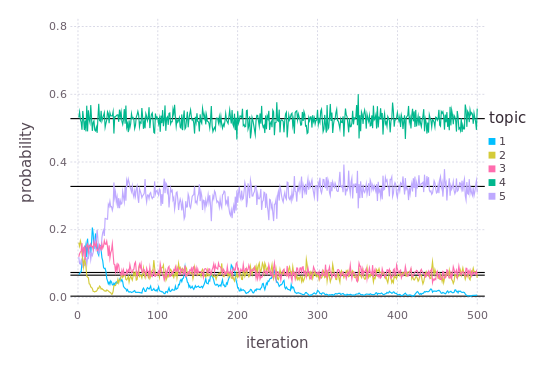

In [415]:
mudat = DataFrame(probability = mapslices(softmax,fits[:η],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=nk./sum(nk),
Geom.line,Geom.hline(color=colorant"black"))

In [441]:
pss = VectorPosterior(PoissonPosterior(0.001,0.001),2);
@time fit = topiclmm(y,X,pss,K,hyperparameter(ν0_σ2η=100.0,σ0_σ2η = 0.001,
  τ0_τ = 1000.0,ν0_τ = 100.0,τ_β = 0.0001),iter=1000,thin=2);
ns = length(fit[:τ]);

  2.277590 seconds (38.86 M allocations: 1.060 GB, 9.26% gc time)


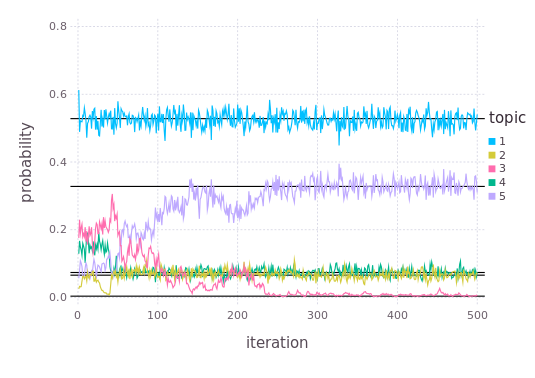

In [442]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=nk./sum(nk),
Geom.line,Geom.hline(color=colorant"black"))

In [395]:
warmup = 0;

In [400]:
θpost1 = Float64[rand(topicpd(fit[:topic][i,j][1]))[1] for j=(warmup+1):ns, i=1:K];
ord = sortperm(vec(mean(θpost1,1)));
phat = @> mapslices(softmax,fit[:η][:,:,(warmup+1):ns],1) mean(3) getindex(ord,:);
pt = mapslices(softmax,η,1);
pdat = DataFrame(TrueProb=pt[:],EstProb=phat[:],RawProb=nk[:]./nd[1],topic=repeat(map(string,1:K),outer=[n]))
plot(layer(pdat,x="TrueProb",y="EstProb",color="topic",Geom.point),
layer(x=[0,1],y=[0,1],Theme(default_color=colorant"black"),Geom.line))

LoadError: LoadError: New columns must have the same length as old columns
while loading In[400], in expression starting on line 5

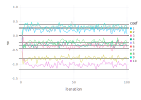

In [57]:
bdat = DataFrame(β = vec( refβ(fit[:β][:,ord,:],fit[:μ][ord,:]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),coef = repeat(map(string,1:(K*p)),outer=[ns]))
plot(bdat,y="β",x="iteration",color="coef",yintercept=vec(refβ(β',μ)),Geom.line,Geom.hline(color=colorant"black"))